# __Create an Image Classification Model__

- Tutorial Difficulty: ★☆☆☆☆
- 10 min read
- Languages: [SQL](https://en.wikipedia.org/wiki/SQL) (100%)
- File location: tutorial_en/thanosql_ml/classification/image_classification.ipynb
- References: [(AI-Hub) Product image data](https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=64), [A ConvNet for the 2020s](https://arxiv.org/abs/2201.03545)

## Tutorial Introduction

<div class="admonition note">
    <h4 class="admonition-title">Understanding Classification</h4>
    <p>Classification is a type of <a href="https://en.wikipedia.org/wiki/Machine_learning">Machine Learning</a> that predicts which category(Category or Class) the target belongs to. For example, both binary classifications(used for classifying men or women) and multiple classifications(used to predict animal species such as dogs, cats, rabbits, etc.) are included in the classification tasks. <br></p>
</div>

The image classification contest([ImageNet](https://en.wikipedia.org/wiki/ImageNet)) has been held since 2010. The winning model at the beginning of the competition showed 72% accuracy. In 2015, the [ResNet](https://arxiv.org/abs/1512.03385) model that won showed 96% accuracy and started to surpass human classification capabilities.

<div class="admonition tip">
   <p>The human ability to classify the same data is estimated at about 95%.</p>
</div>

Even though [Data labeling](https://en.wikipedia.org/wiki/Labeled_data) is important for accurate image classification, methods of correcting the dataset using the weights of the pre-trained model are widely used. This method allows deep learning models training even with a relatively small number of data.

ThanoSQL provides a variety of pre-trained models and allows model creation using simple queries. With this, users can derive insights from images with difficult to quantify features with properly trained models and utilize them for various services.

__The following are examples and applications of the ThanoSQL image classification model.__

- The ThanoSQL image classification model reduces the process of finding suitable categories for product registration in online sales services. You can categorize product images with a simple query. Users can save time compared to traditional image classification by focusing just on correcting some misclassified data.

- Using the image classification model, you can roughly classify art works that would be otherwise difficult to classify due to their vague criteria, such as the feeling, technique, and suitable location of each work.

- You can detect and classify defective products with scratches and damage from manufacturing plants. 

<div class="admonition tip">
   <p>You can also create a classification model based on the behavior of art enthusiasts to classify who is most likely to enjoy a particular piece of art. In other words, using only artwork images, you can create a model that predicts art preferences based on age, gender, place, and etc.
</div>

<div class="admonition note">
   <h4 class="admonition-title">In This Tutorial</h4>
   <p>👉 Build an image classification model to classify more than 10,000 products using the Product Image dataset from <a href="https://aihub.or.kr/">AI-Hub</a>, a data sharing platform. The model can be used for detection and identification in smart warehouses and unmanned stores.
   Dataset consists total of 1,440,000 images. In this tutorial, you will use 1,800 training data and 200 test data to learn how to use ThanoSQL. <br></p>
</div>

[![Product Image Example](https://docs.thanosql.ai/img/thanosql_ml/classification/image_classification/image_classification_data_intro.png "Product Image Example")](https://docs.thanosql.ai/img/thanosql_ml/classification/image_classification/image_classification_data_intro.png)

<div class="admonition warning">
   <h4 class="admonition-title">Tutorial Precautions</h4>
   <ul>
      <li>The image classification model can be used to predict one target value(Target, Category) from one image.</li>
      <li>Both a column representing the image path and a column representing the target value of the image must exist.</li>
      <li>The base model of the corresponding image classification model(<strong>CONVNEXT</strong>) uses GPU. Depending on the size and the batch size of the model used, GPU memory may be insufficient. In this case, try using a smaller model or reducing the batch size of the model.</li>
   </ul>
</div>

## __0. Prepare Dataset__


As mentioned in the [ThanoSQL Workspace](https://docs.thanosql.ai/en/getting_started/paas/workspace/lab/), you must create an API token and run the query below to execute the query of ThanoSQL. 

In [ ]:
%load_ext thanosql
%thanosql API_TOKEN=<Issued_API_TOKEN>

### __Prepare Dataset__

In [2]:
%%thanosql
GET THANOSQL DATASET product_image_data
OPTIONS (overwrite=True)

Success


<div class="admonition note">
    <h4 class="admonition-title">Query Details</h4>
    <ul>
        <li>"<strong>GET THANOSQL DATASET</strong>" downloads the specified dataset to the workspace.</li>
        <li>"<strong>OPTIONS</strong>" specifies the option values to be used for the <strong>GET THANOSQL DATASET</strong> clause.
        <ul>
            <li>"overwrite": determines whether to overwrite a dataset if it already exists. If set as True, the old dataset is replaced with the new dataset (bool, optional, True|False, default: False)</li>
        </ul>
        </li>
    </ul>
</div>

In [3]:
%%thanosql
COPY product_image_train
OPTIONS (if_exists='replace')
FROM 'thanosql-dataset/product_image_data/product_image_train.csv'

Success


In [4]:
%%thanosql
COPY product_image_test
OPTIONS (if_exists='replace')
FROM 'thanosql-dataset/product_image_data/product_image_test.csv'

Success


<div class="admonition note">
    <h4 class="admonition-title">Query Details</h4>
    <ul>
        <li>"<strong>COPY</strong>" specifies the name of the dataset to be saved as a database table.</li>
        <li>"<strong>OPTIONS</strong>" specifies the option values to be used for the <strong>COPY</strong> clause.
        <ul>
           <li>"if_exists": determines how the function should handle the case where the table already exists, it can either raise an error, append to the existing table, or replace the existing table (str, optional, 'fail'|'replace'|'append', default: 'fail')</li>
        </ul>
        </li>
    </ul>
</div>

## __1. Check Dataset__

To create an image classification  model, we use the __product_image_train__ table from the ThanoSQL workspace database. To check the table's contents, run the following query.

In [5]:
%%thanosql
SELECT *
FROM product_image_train
LIMIT 5

,image_path,div_l,div_m,div_s,div_n,comp_nm,img_prod_nm,multi
0,thanosql-dataset/product_image_data/product_im...,유제품,요구르트,떠먹는 요구르트,떠먹는 요구르트,기타,토핑오트&애플시나몬,False
1,thanosql-dataset/product_image_data/product_im...,홈클린,위생용품,일반비누,일반비누,크리오,크리오)골드디비누,True
2,thanosql-dataset/product_image_data/product_im...,면류,용기면,국물용기라면,짬뽕라면,농심,농심오징어짬뽕컵67G,True
3,thanosql-dataset/product_image_data/product_im...,디저트,디저트/베이커리,냉장디저트,냉장디저트,Dole 코리아,Dole후룻볼슬라이스복숭아198g,False
4,thanosql-dataset/product_image_data/product_im...,주류,기타주류,칵테일,칵테일,롯데주류,순하리소다톡바나나355ML,True


<div class="admonition note">
   <h4 class="admonition-title">Understanding the Data Table</h4>
   <p><strong>product_image_train</strong> table contains the following information.</p>
   <ul>
      <li>image_path: image file's path</li>
      <li>div_l: large classification of products</li>
      <li>div_m: middle classification of products</li>
      <li>div_s: subclassification of products</li>
      <li>div_n: detailed classification of products</li>
      <li>comp_nm: manufacturer</li>
      <li>img_prod_nm: product name (image)</li>
      <li>multi: whether image has multiple products</li>
   </ul>
</div>

/home/jovyan/thanosql-dataset/product_image_data/product_image/10246_00_s_21.png


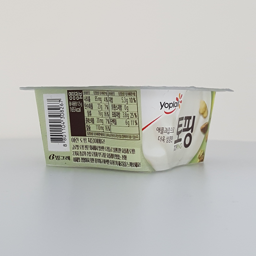

/home/jovyan/thanosql-dataset/product_image_data/product_image/10180_60_m_9.png


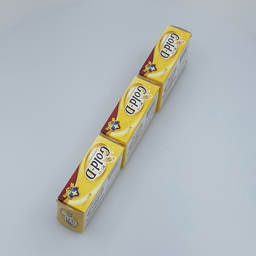

/home/jovyan/thanosql-dataset/product_image_data/product_image/10101_30_m_17.png


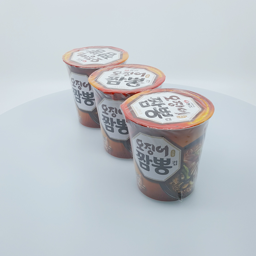

/home/jovyan/thanosql-dataset/product_image_data/product_image/10242_60_s_12.png


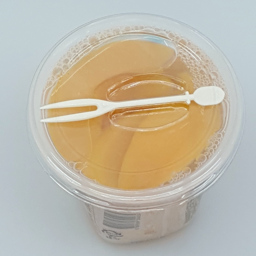

/home/jovyan/thanosql-dataset/product_image_data/product_image/10054_30_m_13.png


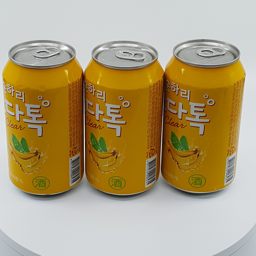

In [6]:
%%thanosql
PRINT IMAGE
AS
SELECT image_path
FROM product_image_train
LIMIT 5

## __2. Build an Image Classification Model__

To create an image classification model with the name __my_product_classifier__ using the __product_image_train__ dataset, run the following query.  
(Estimated duration of query execution: 5 min)

In [7]:
%%thanosql
BUILD MODEL my_product_classifier
USING ConvNeXt_Tiny
OPTIONS (
  image_col='image_path',
  label_col='div_l',
  max_epochs=1,
  overwrite=True
  )
AS
SELECT *
FROM product_image_train

Success


<div class="admonition note">
    <h4 class="admonition-title">Query Details</h4>
    <ul>
        <li>"<strong>BUILD MODEL</strong>" creates and trains a model named <strong>my_product_classifier</strong>.</li>
        <li>"<strong>USING</strong>" specifies <strong>ConvNeXt_Tiny</strong> as the base model.</li>
        <li>"<strong>OPTIONS</strong>" specifies the option values used to create the model.
        <ul>
            <li>"image_col": name of column containing the image path (str, default: 'image_path')</li>
            <li>"label_col": name of the column containing information about the target value (str, default: 'label')</li>
            <li>"max_epochs": number of times to train with the training dataset (int, optional, default: 3)</li>
            <li>"overwrite": determines whether to overwrite a model if it already exists. If set as True, the old model is replaced with the new model (bool, optional, True|False, default: False)</li>
        </ul>
        </li>
    </ul>
</div>

<div class="admonition tip">
    <p>In this example, we set "max_epochs" to 1 to train the model quickly. In general, larger number of "max_epochs" increases performance of the inference at the cost of the computation time.</p>
</div>

## __3. Predict__

To use the image classification model created in the previous step for prediction of __product_image_test__, run the following query.

In [ ]:
%%thanosql
PREDICT USING my_product_classifier
OPTIONS (
    image_col='image_path',
    result_col='predict_result'
    )
AS
SELECT *
FROM product_image_test

,image_path,div_l,div_m,div_s,div_n,comp_nm,img_prod_nm,multi,predict_result
0,thanosql-dataset/product_image_data/product_im...,생활용품,위생용품,면봉,면봉,기타,콩맥스전자담배용크리닝면봉,True,생활용품
1,thanosql-dataset/product_image_data/product_im...,소스,장류,쌈장,쌈장,씨제이제일제당,해찬들고기전용쌈장450G,False,소스
2,thanosql-dataset/product_image_data/product_im...,디저트,디저트/베이커리,냉장디저트,냉장디저트,Dole 코리아,Dole후룻볼슬라이스복숭아198g,False,디저트
3,thanosql-dataset/product_image_data/product_im...,음료,기능성음료,한방음료,한방음료,광동제약,유어스광동어성초500ml,False,음료
4,thanosql-dataset/product_image_data/product_im...,주류,기타주류,칵테일,칵테일,롯데주류,순하리소다톡바나나355ML,False,주류
...,...,...,...,...,...,...,...,...,...
197,thanosql-dataset/product_image_data/product_im...,의약외품,기능성음료,숙취해소음료,숙취해소음료,동아제약,동아제약)가그린제로100ML,False,의약외품
198,thanosql-dataset/product_image_data/product_im...,소스,장류,쌈장,쌈장,씨제이제일제당,해찬들고기전용쌈장450G,True,소스
199,thanosql-dataset/product_image_data/product_im...,주류,기타주류,칵테일,칵테일,롯데주류,순하리소다톡바나나355ML,True,주류
200,thanosql-dataset/product_image_data/product_im...,유제품,요구르트,떠먹는 요구르트,떠먹는 요구르트,기타,토핑오트&애플시나몬,False,유제품


<div class="admonition note">
    <h4 class="admonition-title">Query details</h4>
    <ul>
        <li>"<strong>PREDICT USING</strong>" predicts the outcome using the <strong>my_product_classifier</strong>.
        <li>"<strong>OPTIONS</strong>" specifies the option values to be used for prediction.
        <ul>
            <li>"image_col": the name of the column where the path of the image used for prediction is stored (str, default: 'image_path')</li>
            <li>"result_col": the column that contains the predicted results (str, optional, default: 'predict_result')</li>
        </ul>
        </li>
    </ul>
</div>

## __4. In Conclusion__

In this tutorial, we created an image classification model using the product image dataset. As this is a beginner-level tutorial, we focused on the process rather than accuracy. The image classification model can be improved in accuracy through fine tuning that is suitable for the user's needs. It is also possible to train the base model using your own data, or to vectorize and transform your data using a self-supervised model, and then distributing it using automated machine learning(AutoML) technique. Create your own model and provide competitive services by combining various unstructured data(image, audio, video, etc.) and structured data with ThanoSQL.

* [How to Upload My Data to the ThanoSQL Workspace](https://docs.thanosql.ai/en/getting_started/data_upload/)
* [How to Create a Table Using My Data](https://docs.thanosql.ai/en/how-to_guides/ThanoSQL_query/COPY_SYNTAX/)
* [How to Upload My Model to the ThanoSQL Workspace](https://docs.thanosql.ai/en/how-to_guides/ThanoSQL_query/UPLOAD_MODEL_SYNTAX/)

<div class="admonition tip">
    <h4 class="admonition-title">Inquiries About Deploying a Model for Your Own Service</h4>
    <p>If you have any difficulties creating your own model using ThanoSQL or applying it to your service, please feel free to contact us below😊</p>
    <p>For inquiries regarding building an image classification model: <a href="mailto:contact@smartmind.team">contact@smartmind.team</a></p>
</div>